# Visualización de video en Jupyter Notebook

In [1]:
# Importación de librerías
import cv2  # Para manejo de video y procesamiento de imágenes
from IPython.display import display, HTML  # Para mostrar el video en el notebook
from base64 import b64encode  # Para codificar el video en base64
import matplotlib.pyplot as plt  # Para visualización de imágenes

## Carga del video

En esta sección, cargamos el video desde una ruta específica y verificamos que se haya abierto correctamente.

In [2]:
# Ruta al video
video_path = "data/input/video_1.mp4" 

# Leer el video
video = cv2.VideoCapture(video_path)

# Verificar si el video se abrió correctamente
if not video.isOpened():
    print("Error: No se pudo abrir el video.")
else:
    print("Video cargado correctamente.")

Video cargado correctamente.


## Visualización del primer frame

A continuación, mostramos el primer frame del video para verificar que se ha cargado correctamente.

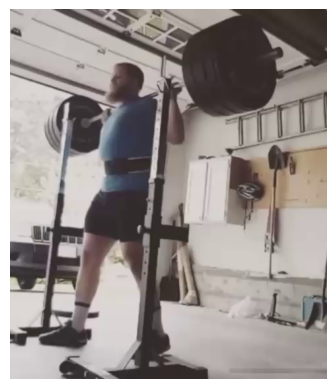

In [3]:
# Leer el primer frame del video
ret, frame = video.read()
if ret:
    # Convertir el frame de BGR (OpenCV) a RGB (para visualización)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Mostrar el primer frame en el notebook
    plt.imshow(frame_rgb)
    plt.axis('off')  # Ocultar ejes
    plt.show()
else:
    print("Error: No se pudo leer el primer frame del video.")

# Liberar el video (si solo estás mostrando el primer frame)
video.release()

## Reproducción del video completo

En esta sección, reproducimos el video completo en el notebook utilizando HTML5.

In [4]:
# Crear un reproductor de video HTML5
video_html = f"""
<video width="640" height="480" controls>
    <source src="{video_path}" type="video/mp4">
    Tu navegador no soporta la reproducción de videos.
</video>
"""

# Mostrar el reproductor de video en el notebook
display(HTML(video_html))

## Funcion para reproducir un video

In [5]:
def display_video(video_path:str):
    video = cv2.VideoCapture(video_path)    
    if not video.isOpened():
        print("Error: No se pudo abrir el video.")
    else:
        video_html = f"""
        <video width="640" height="480" controls>
            <source src="{video_path}" type="video/mp4">
            Tu navegador no soporta la reproducción de videos.
        </video>
        """
        display(HTML(video_html))

# Evaluación de Trackers

En este análisis, evaluaremos el rendimiento de diferentes trackers disponibles en OpenCV. Utilizaremos el **Intersection over Union (IoU)** como métrica principal para comparar la precisión de cada tracker.  

El proceso de evaluación consiste en:  

1. **Inicializar** múltiples trackers sobre el mismo objeto en un video.  
2. **Actualizar** los trackers en cada fotograma y obtener sus bounding boxes.  
3. **Comparar** cada tracker con la ground truth usando **IoU**.  
4. **Analizar** los resultados para determinar cuál es más preciso y estable.  

Se utilizarán los siguientes trackers:  

- BOOSTING  
- MIL  
- KCF  
- TLD  
- MEDIANFLOW  
- MOSSE  
- CSRT  

El objetivo es identificar qué tracker ofrece el mejor rendimiento en términos de precisión y estabilidad para diferentes condiciones del video.  

## Funciones auxiliares

A continuación, se definen las funciones auxiliares necesarias para el análisis de sentadillas:
- `scale_landmarks`: Escala los landmarks (puntos clave) de MediaPipe a las dimensiones del frame.
- `draw_lines_and_angle`: Dibuja líneas y ángulos en el frame.
- `detect_objects`: Detecta objetos en el frame (en este caso, la persona que realiza la sentadilla).
- `display_video`: Muestra el video generado en el notebook.

In [6]:
from utils import scale_landmarks, draw_lines_and_angle, detect_objects

In [7]:
def calculate_iou(boxA, boxB):
        """
        Calcula el Intersection over Union (IoU) entre dos cajas delimitadoras.
        Las cajas están en formato (x, y, w, h).
        """
        # Coordenadas de las esquinas de las cajas
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
        yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

        # Calcula el área de intersección
        interWidth = max(0, xB - xA)
        interHeight = max(0, yB - yA)
        interArea = interWidth * interHeight

        # Calcula el área de unión
        boxAArea = boxA[2] * boxA[3]
        boxBArea = boxB[2] * boxB[3]
        unionArea = boxAArea + boxBArea - interArea

        # Calcula IoU
        if unionArea == 0:
            return 0  # Evitar división por cero
        return interArea / unionArea
    
def evaluate_video(video_path, trackers_dict):
    
    video = cv2.VideoCapture(video_path)
    ret, frame = video.read()

    if not video.isOpened():
        print(f"No se pudo abrir el video en la ruta {data_video_path}{video_name}.mp4")
        exit()

    bounding_boxes = detect_objects(source=frame, conf=0.2, line_width=2, classes=0)
    while len(bounding_boxes) == 0:
        ret, frame = video.read()
        bounding_boxes = detect_objects(source=frame, conf=0.2, line_width=2, classes=0)
        if not ret:
            print("No se detectaron objetos en el video")
            exit()

    bbox = (bounding_boxes[0]["x"], bounding_boxes[0]["y"], bounding_boxes[0]["w"], bounding_boxes[0]["h"])
    
    for name, tracker in trackers_dict.items():
        success = tracker.init(frame, bbox)
        print(f"Tracker {name} inicializado")
    print("")
    
    iou_per_tracker = {name: 0 for name in trackers_dict.keys()}
    frame_count = 0

    while True:
        ret, frame = video.read()
        if not ret:
            break

        bounding_boxes = detect_objects(source=frame, conf=0.2, line_width=2, classes=0)
        if len(bounding_boxes) > 0:
            # Bounding box de la predicción
            pred_bbox = (bounding_boxes[0]["x"], bounding_boxes[0]["y"], bounding_boxes[0]["w"], bounding_boxes[0]["h"])
            cv2.rectangle(frame, (pred_bbox[0], pred_bbox[1]), 
                        (pred_bbox[0] + pred_bbox[2], pred_bbox[1] + pred_bbox[3]), (0, 255, 0), 2, 1)
        else:
            continue  # No hay predicción, saltar este frame

        # Actualiza cada tracker
        for name, tracker in trackers_dict.items():
            success, track_bbox = tracker.update(frame)

            if success:
                x, y, w, h = [int(i) for i in track_bbox]
                # Bounding box del tracker
                track_bbox = (x, y, w, h)

                # Calcula IoU y acumula
                iou = calculate_iou(pred_bbox, track_bbox)
                iou_per_tracker[name] += iou

        frame_count += 1

    video.release()

    
    # Calcula la precisión general
    if frame_count > 0:
        for name in trackers_dict.keys():
            average_iou = iou_per_tracker[name] / frame_count
            print(f"Precisión promedio del tracker {name} es: {average_iou:.4f}")
    else:
        print("No se calculó IoU debido a la falta de frames con detecciones válidas.") 

In [8]:
trackers_dict = {
    'BOOSTING': cv2.legacy.TrackerBoosting_create(),
    'MIL': cv2.TrackerMIL_create(),
    'KCF': cv2.TrackerKCF_create(),
    'TLD': cv2.legacy.TrackerTLD_create(),
    'MEDIANFLOW': cv2.legacy.TrackerMedianFlow_create(),
    'MOSSE': cv2.legacy.TrackerMOSSE_create(),
    'CSRT': cv2.legacy.TrackerCSRT_create()
}
video_path = "data/input/video_1.mp4" 

evaluate_video(video_path, trackers_dict)

Tracker BOOSTING inicializado
Tracker MIL inicializado
Tracker KCF inicializado
Tracker TLD inicializado
Tracker MEDIANFLOW inicializado
Tracker MOSSE inicializado
Tracker CSRT inicializado

Precisión promedio del tracker BOOSTING es: 0.7279
Precisión promedio del tracker MIL es: 0.6595
Precisión promedio del tracker KCF es: 0.6976
Precisión promedio del tracker TLD es: 0.1293
Precisión promedio del tracker MEDIANFLOW es: 0.3978
Precisión promedio del tracker MOSSE es: 0.0000
Precisión promedio del tracker CSRT es: 0.6076


# Análisis de Resultados y Selección del Mejor Tracker  

Tras evaluar diferentes trackers en OpenCV utilizando **Intersection over Union (IoU)** como métrica de precisión, obtuvimos los siguientes resultados promedio:  

| Tracker       | Precisión Promedio |
|--------------|------------------|
| BOOSTING     | 0.7279           |
| MIL         | 0.6595           |
| KCF         | 0.6976           |
| TLD         | 0.1293           |
| MEDIANFLOW  | 0.3978           |
| MOSSE       | 0.0000           |
| CSRT        | 0.6076           |

### Selección del Mejor Tracker  

El tracker con mejor rendimiento es **BOOSTING**, con una precisión promedio de **0.7279**, superando a los demás en términos de estabilidad y precisión en la estimación de la posición del objeto.  

Por lo tanto, **BOOSTING** será el tracker seleccionado para futuras implementaciones.  


# Análisis de sentadillas (Squat) en video

Este notebook realiza un análisis de sentadillas (squat) en un video utilizando MediaPipe para la detección de poses y OpenCV para el procesamiento de video. Además, se genera una gráfica que muestra la altura del bbox (caja delimitadora) a lo largo del tiempo.

In [9]:
# Importación de librerías
import cv2
import mediapipe as mp
import os
import ffmpeg
from IPython.display import display, HTML

## Análisis de sentadillas

En esta sección, se realiza el análisis de sentadillas en el video. Se detecta la pose de la persona, se rastrea su movimiento y se genera una gráfica que muestra la altura del bbox a lo largo del tiempo.

### Inicialización del tracker y listas de datos

En esta sección, se inicializa el tracker (`cv2.legacy.TrackerBoosting_create()`) para seguir el movimiento de la persona en el video. También se definen listas para almacenar el número de frames y las alturas del bbox (caja delimitadora).

In [10]:
# Inicializar el tracker
tracker = cv2.legacy.TrackerBoosting_create()

# Listas para almacenar datos de frames y alturas del bbox
frame_numbers = []
bbox_heights = []

### Función `process_video`

Esta función realiza el análisis de sentadillas en el video. Se encarga de:
1. Inicializar MediaPipe Pose para la detección de la pose.
2. Leer el video de entrada y obtener sus propiedades.
3. Rotar el video si está en formato horizontal.
4. Detectar la persona en el video y rastrear su movimiento.
5. Dibujar las poses detectadas y el bbox en cada frame.
6. Registrar la altura del bbox en cada frame.
7. Generar una gráfica que muestra la altura del bbox a lo largo del tiempo.
8. Guardar el video procesado.

In [11]:
def process_video(input_path, output_path):
    # Inicializar MediaPipe Pose
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()

    # Leer el video de entrada
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el video {input_path}")
        return

    # Obtener las propiedades del video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec para .avi

    if width > height:
        print("El video está en formato horizontal, se rotará 90° en sentido horario.")
        width, height = height, width
        rotate = True
    else:
        rotate = False

    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    ret, frame = cap.read()
    if rotate:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    bounding_boxes = detect_objects(source=frame, conf=0.2, line_width=2, classes=0)
    while len(bounding_boxes) == 0:
        ret, frame = cap.read()
        bounding_boxes = detect_objects(source=frame, conf=0.2, line_width=2, classes=0)
        if not ret:
            print("No se detectaron objetos en el video")
            exit()
    bbox = (bounding_boxes[0]["x"], bounding_boxes[0]["y"], bounding_boxes[0]["w"], bounding_boxes[0]["h"])
    print(f"Objeto detectado en -> {bbox}")
    tracker.init(frame, bbox)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Rotar el frame si es necesario
        if rotate:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

        # Convertir la imagen a RGB (MediaPipe trabaja en RGB)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Realizar la detección de pose
        results = pose.process(rgb_frame)

        success, bbox = tracker.update(frame)

        # Dibujar las poses detectadas en el frame
        if results.pose_landmarks:
            right_knee_points = scale_landmarks(
                [results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP.value],
                    results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                    results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE.value]],
                width, height
            )
            left_knee_points = scale_landmarks(
                [results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP.value],
                    results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE.value],
                    results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE.value]],
                width, height
            )
            right_hip_points = scale_landmarks(
                [results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                    results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP.value],
                    results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE.value]],
                width, height
            )
            left_hip_points = scale_landmarks(
                [results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                    results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP.value],
                    results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE.value]],
                width, height
            )

            draw_lines_and_angle(frame, (right_knee_points,left_knee_points))    
            draw_lines_and_angle(frame, (right_hip_points, left_hip_points))

        if success:
            # Dibuja la caja delimitadora
            x, y, w, h = [int(i) for i in bbox]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2, 1)
            frame_numbers.append(len(frame_numbers) + 1)
            bbox_heights.append(y + h)
        else:
            cv2.putText(frame, "Tracking perdido", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

        # Escribir el frame procesado en el video de salida
        out.write(frame)

    # Liberar recursos
    cap.release()
    out.release()

    print(f"Video procesado y guardado en {output_path}")

### Uso del script

A continuación, se muestra cómo utilizar la función `process_video` para analizar un video y generar el video procesado.

In [13]:
# Uso del script
video = "video_1"
video_path = "data/input/video_1.mp4" 

input_video = f"data/input/{video}.mp4"

video_avi = f"data/output/{video}/video_tracker.avi"
process_video(input_video, video_avi)

video_mp4 = f"data/output/{video}/video_tracker.mp4"

ffmpeg.input(video_avi).output(video_mp4, vcodec="libx264", acodec="aac").overwrite_output().run()
# Borra el archivo .avi 
os.remove(video_avi)    
print("Conversión completada.")

I0000 00:00:1740710945.375222  105833 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1740710945.396292  111509 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA GeForce GTX 1060 6GB/PCIe/SSE2
W0000 00:00:1740710945.474073  111506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1740710945.521228  111507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Objeto detectado en -> (292, 33, 142, 147)


W0000 00:00:1740710956.995347  111505 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Video procesado y guardado en data/output/video_1/video_tracker.avi


ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

Conversión completada.


[out#0/mp4 @ 0x5b8175d4e8c0] video:1120kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.677185%
frame=  588 fps=355 q=-1.0 Lsize=    1127kB time=00:00:11.03 bitrate= 836.6kbits/s speed=6.67x    
[libx264 @ 0x5b8175d50100] frame I:3     Avg QP:22.35  size: 21296
[libx264 @ 0x5b8175d50100] frame P:184   Avg QP:24.69  size:  3960
[libx264 @ 0x5b8175d50100] frame B:401   Avg QP:31.37  size:   881
[libx264 @ 0x5b8175d50100] consecutive B-frames:  3.6% 14.3%  6.6% 75.5%
[libx264 @ 0x5b8175d50100] mb I  I16..4:  7.3% 78.1% 14.6%
[libx264 @ 0x5b8175d50100] mb P  I16..4:  1.1%  4.1%  1.2%  P16..4: 24.6% 10.7%  7.9%  0.0%  0.0%    skip:50.4%
[libx264 @ 0x5b8175d50100] mb B  I16..4:  0.1%  0.3%  0.1%  B16..8: 17.5%  2.8%  0.9%  direct: 0.6%  skip:77.7%  L0:34.8% L1:62.0% BI: 3.2%
[libx264 @ 0x5b8175d50100] 8x8 transform intra:65.0% inter:63.0%
[libx264 @ 0x5b8175d50100] coded y,uvDC,uvAC intra: 52.6% 47.4% 16.3% inter: 5.7% 6.2% 3.1%
[libx264 @ 0x5b8175d50100] i16

### Visualización del video generado

Finalmente, se muestra el video procesado utilizando la función `display_video`.

In [14]:
# Mostrar el video generado
display_video(video_mp4)

### Visualización grafica del levantamiento


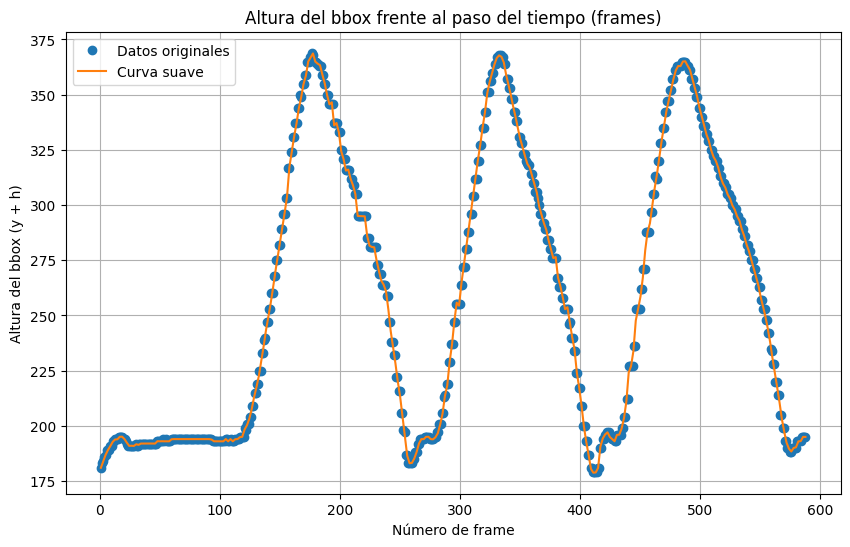

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Datos de ejemplo (reemplaza con tus valores reales)
frame_numbers = np.array(frame_numbers)
bbox_heights = np.array(bbox_heights)

# Crear una curva suave usando splines
spline = make_interp_spline(frame_numbers, bbox_heights, k=2) # k=2 para spline cuadratico
frame_numbers_smooth = np.linspace(frame_numbers.min(), frame_numbers.max(), 300)  # Más puntos para suavizar
bbox_heights_smooth = spline(frame_numbers_smooth)

# Graficar la curva suave
plt.figure(figsize=(10, 6))
plt.plot(frame_numbers, bbox_heights, 'o', label="Datos originales")
plt.plot(frame_numbers_smooth, bbox_heights_smooth, '-', label="Curva suave")
plt.title("Altura del bbox frente al paso del tiempo (frames)")
plt.xlabel("Número de frame")
plt.ylabel("Altura del bbox (y + h)")
plt.legend()
plt.grid(True)
plt.show()

> Ahora se debe hallar los puntos claves donde comienza y termina cada repeticion 💪

In [16]:
import numpy as np
from scipy.signal import find_peaks

def find_flat_points(signal, peaks, height=None, distance=None, threshold=0.1, min_distance_from_peak=2):
    """
    Encuentra los puntos donde la derivada de la señal es cercana a cero, excluyendo aquellos cercanos a los picos.

    Parámetros:
        signal (array): La señal de entrada (altura del bbox, por ejemplo).
        peaks (array): Índices de los picos (máximos) en la señal.
        height (float o tuple): Umbral de altura para los puntos planos.
        distance (int): Distancia mínima entre puntos planos.
        threshold (float): Umbral para considerar que la derivada es cercana a cero.
        min_distance_from_peak (int): Distancia mínima permitida entre un flat_point y un pico.

    Retorna:
        flat_points (array): Índices de los puntos donde la derivada es cercana a cero.
        properties (dict): Propiedades de los puntos detectados.
    """
    # Calcular la derivada de la señal
    derivative = np.gradient(signal)

    # Encontrar los puntos donde la derivada es cercana a cero (dentro del umbral)
    flat_indices = np.where(np.abs(derivative) < threshold)[0]

    # Si no hay puntos cercanos a cero, retornar vacío
    if len(flat_indices) == 0:
        return np.array([]), {}

    # Crear una señal auxiliar con -abs(derivative) para usar find_peaks
    aux_signal = -np.abs(derivative)

    # Encontrar los "picos" en la señal auxiliar (que corresponden a valles en la derivada)
    flat_points, properties = find_peaks(
        aux_signal,
        height=height,
        distance=distance,
    )

    # Filtrar los puntos para asegurarnos de que estén en flat_indices
    flat_points = np.intersect1d(flat_points, flat_indices)

    # Excluir flat_points que estén demasiado cerca de los picos
    if len(peaks) > 0:
        # Crear una máscara para excluir puntos cercanos a los picos
        mask = np.ones_like(flat_points, dtype=bool)
        for peak in peaks:
            # Excluir puntos dentro de min_distance_from_peak frames del pico
            mask &= (np.abs(flat_points - peak) > min_distance_from_peak)
        
        # Aplicar la máscara para filtrar flat_points
        flat_points = flat_points[mask]

    return flat_points, properties

valleys: [ 17  23  33  45  59  76  99 261 273 412 427 578 582]


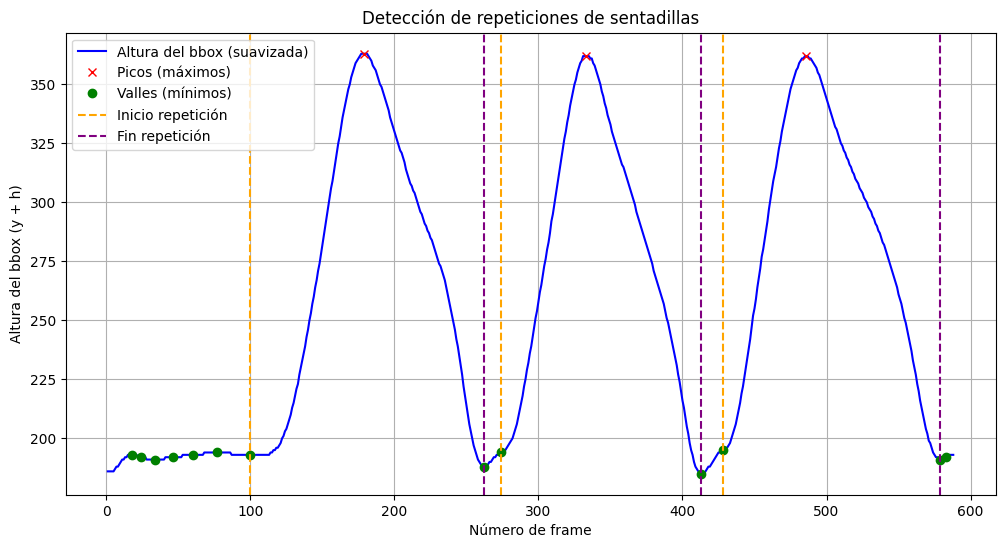

Repetición 1:
  - Inicio: Frame 100
  - Pico: Frame 178
  - Fin:    Frame 262
Repetición 2:
  - Inicio: Frame 274
  - Pico: Frame 332
  - Fin:    Frame 413
Repetición 3:
  - Inicio: Frame 428
  - Pico: Frame 485
  - Fin:    Frame 579


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, find_peaks

# 1. Suavizar la señal (opcional, dependiendo del ruido en los datos)
from scipy.ndimage import uniform_filter1d
bbox_heights_smooth = uniform_filter1d(bbox_heights, size=16)  # Filtro de media móvil

# 2. Encontrar los picos (máximos) y valles (mínimos)
# Detectar picos (máximos)
peaks, _ = find_peaks(bbox_heights_smooth, height=np.mean(bbox_heights_smooth), distance=20)
# Detectar valles (mínimos)
#valleys, _ = find_peaks(-bbox_heights_smooth, height=np.mean(-bbox_heights_smooth), distance=20)
valleys, _ = find_flat_points(
    bbox_heights_smooth,
    height=np.mean(-np.abs(np.gradient(bbox_heights_smooth))),
    distance=4, 
    threshold=0.01, 
    peaks=peaks,
    min_distance_from_peak=2
)

# 3. Identificar los puntos de inicio y fin de cada repetición
# Los puntos de inicio son los valles antes de cada pico
start_frames = []
# Los puntos de fin son los valles después de cada pico
end_frames = []

print(f"valleys: {valleys}")
for peak in peaks:
    # Encontrar el valle más cercano antes del pico
    start_frame = valleys[valleys < peak][-1] if any(valleys < peak) else None
    # Encontrar el valle más cercano después del pico
    end_frame = valleys[valleys > peak][0] if any(valleys > peak) else None
    
    if start_frame and end_frame:
        start_frames.append(start_frame)
        end_frames.append(end_frame)

# 4. Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(frame_numbers, bbox_heights_smooth, label="Altura del bbox (suavizada)", color='blue')
plt.plot(frame_numbers[peaks], bbox_heights_smooth[peaks], "x", label="Picos (máximos)", color='red')
plt.plot(frame_numbers[valleys], bbox_heights_smooth[valleys], "o", label="Valles (mínimos)", color='green')

# Marcar los puntos de inicio y fin de cada repetición
for start, end in zip(start_frames, end_frames):
    plt.axvline(x=frame_numbers[start], color='orange', linestyle='--', label="Inicio repetición" if start == start_frames[0] else "")
    plt.axvline(x=frame_numbers[end], color='purple', linestyle='--', label="Fin repetición" if end == end_frames[0] else "")

plt.title("Detección de repeticiones de sentadillas")
plt.xlabel("Número de frame")
plt.ylabel("Altura del bbox (y + h)")
plt.legend()
plt.grid(True)
plt.savefig("rep_squat_graph.png")
plt.show()

# 5. Mostrar los fotogramas de inicio y fin de cada repetición
for i, (start, end) in enumerate(zip(start_frames, end_frames)):
    print(f"Repetición {i + 1}:")
    print(f"  - Inicio: Frame {frame_numbers[start]}")
    print(f"  - Pico: Frame {peaks[i]}")
    print(f"  - Fin:    Frame {frame_numbers[end]}")

## Procesamiento final de video

In [18]:
def final_process_video(input_path, output_path, start_frames, end_frames, peaks, sec_pause=3):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el video {input_path}")
        return
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec para .avi
    if width > height:
        print("El video está en formato horizontal, se rotará 90° en sentido horario.")
        width, height = height, width
        rotate = True
    else:
        rotate = False
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    ret, frame = cap.read()
    if rotate:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    bounding_boxes = detect_objects(source=frame, conf=0.2, line_width=2, classes=0)
    while len(bounding_boxes) == 0:
        ret, frame = cap.read()
        bounding_boxes = detect_objects(source=frame, conf=0.2, line_width=2, classes=0)
        if not ret:
            print("No se detectaron objetos en el video")
            exit()
    bbox = (bounding_boxes[0]["x"], bounding_boxes[0]["y"], bounding_boxes[0]["w"], bounding_boxes[0]["h"])
    print(f"Objeto detectado en -> {bbox}")
    tracker.init(frame, bbox)
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if rotate:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        
        success, bbox = tracker.update(frame)

        if (frame_count in start_frames) or (frame_count in end_frames) or (frame_count in peaks):
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb_frame)
            # Dibujar las poses detectadas en el frame
            if results.pose_landmarks:
                right_knee_points = scale_landmarks(
                    [results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE.value]],
                    width, height
                )
                left_knee_points = scale_landmarks(
                    [results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE.value]],
                    width, height
                )
                right_hip_points = scale_landmarks(
                    [results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE.value]],
                    width, height
                )
                left_hip_points = scale_landmarks(
                    [results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE.value]],
                    width, height
                )
                if frame_count in start_frames:
                    cv2.putText(frame, "Inicio de sentadilla", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                if frame_count in end_frames:
                    cv2.putText(frame, "Fin de sentadilla", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                if frame_count in peaks:
                    cv2.putText(frame, "Punto minimo", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

                draw_lines_and_angle(frame, (right_knee_points,left_knee_points))    
                draw_lines_and_angle(frame, (right_hip_points, left_hip_points))
                for _ in range(int(fps*sec_pause)):
                    out.write(frame)
                    
        if success:
            # Dibuja la caja delimitadora
            x, y, w, h = [int(i) for i in bbox]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2, 1)
        else:
            cv2.putText(frame, "Tracking perdido", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

        # Escribir el frame procesado en el video de salida
        out.write(frame)
        frame_count += 1

    # Liberar recursos
    cap.release()
    out.release()

    print(f"Video procesado y guardado en {output_path}")

In [21]:
tracker = cv2.legacy.TrackerBoosting_create()

video = "video_1"
input_video = f"data/input/{video}.mp4"
video_avi = f"data/output/{video}/video_tracker.avi"

final_process_video(input_video, video_avi, start_frames, end_frames, peaks)

video_mp4 = f"data/output/{video}/video_tracker.mp4"

ffmpeg.input(video_avi).output(video_mp4, vcodec="libx264", acodec="aac").overwrite_output().run()
# Borra el archivo .avi 
os.remove(video_avi)    
print("Conversión completada.")

I0000 00:00:1740711217.644840  105833 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1740711217.675734  112907 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA GeForce GTX 1060 6GB/PCIe/SSE2
W0000 00:00:1740711217.757076  112902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1740711217.801345  112901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Objeto detectado en -> (292, 33, 142, 147)
Video procesado y guardado en data/output/video_1/video_tracker.avi


ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

Conversión completada.


[out#0/mp4 @ 0x5d003bd2b5c0] video:1079kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.213172%
frame= 2019 fps=584 q=-1.0 Lsize=    1103kB time=00:00:38.03 bitrate= 237.5kbits/s speed=  11x    
[libx264 @ 0x5d003bd2cdc0] frame I:9     Avg QP:19.83  size: 27409
[libx264 @ 0x5d003bd2cdc0] frame P:654   Avg QP:22.39  size:  1137
[libx264 @ 0x5d003bd2cdc0] frame B:1356  Avg QP:30.49  size:    84
[libx264 @ 0x5d003bd2cdc0] consecutive B-frames:  5.8% 12.4%  4.8% 77.1%
[libx264 @ 0x5d003bd2cdc0] mb I  I16..4:  6.4% 79.1% 14.5%
[libx264 @ 0x5d003bd2cdc0] mb P  I16..4:  0.4%  1.6%  0.3%  P16..4: 10.2%  3.5%  2.5%  0.0%  0.0%    skip:81.7%
[libx264 @ 0x5d003bd2cdc0] mb B  I16..4:  0.0%  0.1%  0.0%  B16..8:  4.5%  0.2%  0.0%  direct: 0.0%  skip:95.1%  L0:38.4% L1:60.6% BI: 1.0%
[libx264 @ 0x5d003bd2cdc0] 8x8 transform intra:75.1% inter:69.7%
[libx264 @ 0x5d003bd2cdc0] coded y,uvDC,uvAC intra: 56.9% 45.8% 10.8% inter: 1.6% 1.3% 0.2%
[libx264 @ 0x5d003bd2cdc0] i16

In [22]:
# Mostrar el video generado
display_video(video_mp4)

# Final Script

In [23]:
# Inicializar el tracker
tracker = cv2.legacy.TrackerBoosting_create()

# Listas para almacenar datos de frames y alturas del bbox
frame_numbers = []
bbox_heights = []

initial_frame = 0

In [24]:
def analize_bbox(video_path, output_path):
    global initial_frame
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    video_folder = os.path.join(output_path, video_name)
    os.makedirs(video_folder, exist_ok=True)

    video_avi = os.path.join(video_folder, "video_tracker.avi")
    video_mp4 = os.path.join(video_folder, "video_tracker.mp4")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el video {video_path}")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec para .avi

    if width > height:
        print("El video está en formato horizontal, se rotará 90° en sentido horario.")
        width, height = height, width
        rotate = True
    else:
        rotate = False
    
    out = cv2.VideoWriter(video_avi, fourcc, fps, (width, height))

    ret, frame = cap.read()
    if rotate:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    bounding_boxes = detect_objects(source=frame, conf=0.2, line_width=2, classes=0)
    while len(bounding_boxes) == 0:
        ret, frame = cap.read()
        initial_frame += 1
        bounding_boxes = detect_objects(source=frame, conf=0.2, line_width=2, classes=0)
        if not ret:
            print("No se detectaron objetos en el video")
            exit()
    bbox = (bounding_boxes[0]["x"], bounding_boxes[0]["y"], bounding_boxes[0]["w"], bounding_boxes[0]["h"])
    tracker.init(frame, bbox)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if rotate:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

        success, bbox = tracker.update(frame)

        if success:
            # Dibuja la caja delimitadora
            x, y, w, h = [int(i) for i in bbox]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2, 1)
            frame_numbers.append(len(frame_numbers) + 1)
            bbox_heights.append(y + h)
        else:
            cv2.putText(frame, "Tracking perdido", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

        out.write(frame)

    # Liberar recursos
    cap.release()
    out.release()
    
    ffmpeg.input(video_avi).output(video_mp4, vcodec="libx264", acodec="aac").overwrite_output().run()
    # Borra el archivo .avi 
    os.remove(video_avi)   

    print(f"Video procesado y guardado en {video_mp4}")

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, find_peaks
from scipy.ndimage import uniform_filter1d

def detect_squat_repetitions(bbox_heights, frame_numbers, output_path, size=16,
                             distance=5, threshold=0.01, min_distance_from_peak=2):
    # 1. Suavizar la señal
    frame_numbers = np.array(frame_numbers)
    bbox_heights = np.array(bbox_heights)
    bbox_heights_smooth = uniform_filter1d(bbox_heights, size=size)
    
    # 2. Encontrar picos (máximos) y valles (mínimos)
    peaks, _ = find_peaks(bbox_heights_smooth, height=np.mean(bbox_heights_smooth), distance=20)
    valleys, _ = find_flat_points(
        bbox_heights_smooth,
        height=np.mean(-np.abs(np.gradient(bbox_heights_smooth))),
        distance=distance,
        threshold=threshold,
        peaks=peaks,
        min_distance_from_peak=min_distance_from_peak
    )
    
    # 3. Identificar los puntos de inicio y fin de cada repetición
    start_frames = []
    end_frames = []
    
    for peak in peaks:
        start_frame = valleys[valleys < peak][-1] if any(valleys < peak) else None
        end_frame = valleys[valleys > peak][0] if any(valleys > peak) else None
        
        if start_frame is not None and end_frame is not None:
            start_frames.append(start_frame)
            end_frames.append(end_frame)
    
    # 4. Graficar los resultados
    plt.figure(figsize=(12, 6))
    plt.plot(frame_numbers, bbox_heights_smooth, label="Altura del bbox (suavizada)", color='blue')
    plt.plot(frame_numbers[peaks], bbox_heights_smooth[peaks], "x", label="Picos (máximos)", color='red')
    plt.plot(frame_numbers[valleys], bbox_heights_smooth[valleys], "o", label="Valles (mínimos)", color='green')
    
    for start, end in zip(start_frames, end_frames):
        plt.axvline(x=frame_numbers[start], color='orange', linestyle='--', label="Inicio repetición" if start == start_frames[0] else "")
        plt.axvline(x=frame_numbers[end], color='purple', linestyle='--', label="Fin repetición" if end == end_frames[0] else "")
    
    plt.title("Detección de repeticiones de sentadillas")
    plt.xlabel("Número de frame")
    plt.ylabel("Altura del bbox (y + h)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{output_path}/rep_squat_graph.png")
    plt.show()
    
    # 5. Mostrar los fotogramas de inicio y fin de cada repetición
    for i, (start, end) in enumerate(zip(start_frames, end_frames)):
        print(f"Repetición {i + 1}:")
        print(f"  - Inicio: Frame {frame_numbers[start]}")
        print(f"  - Pico: Frame {peaks[i]}")
        print(f"  - Fin:    Frame {frame_numbers[end]}")
    
    return start_frames, end_frames, peaks

In [26]:
def create_video(video_path, output_path, start_frames,
                 end_frames, peaks, sec_pause=3, initial_frame=0):
    
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    video_folder = os.path.join(output_path, video_name)
    os.makedirs(video_folder, exist_ok=True)

    video_avi = os.path.join(video_folder, "result.avi")
    video_mp4 = os.path.join(video_folder, "result.mp4")

    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el video {video_path}")
        return
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec para .avi
    
    if width > height:
        print("El video está en formato horizontal, se rotará 90° en sentido horario.")
        width, height = height, width
        rotate = True
    else:
        rotate = False
        
    out = cv2.VideoWriter(video_avi, fourcc, fps, (width, height))
    for _ in range(initial_frame+1):
        ret, frame = cap.read()
    if rotate:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if rotate:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        
        if (frame_count in start_frames) or (frame_count in end_frames) or (frame_count in peaks):
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb_frame)
            # Dibujar las poses detectadas en el frame
            if results.pose_landmarks:
                right_knee_points = scale_landmarks(
                    [results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE.value]],
                    width, height
                )
                left_knee_points = scale_landmarks(
                    [results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE.value]],
                    width, height
                )
                right_hip_points = scale_landmarks(
                    [results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE.value]],
                    width, height
                )
                left_hip_points = scale_landmarks(
                    [results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP.value],
                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE.value]],
                    width, height
                )
                if frame_count in start_frames:
                    cv2.putText(frame, "Inicio de sentadilla", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                if frame_count in end_frames:
                    cv2.putText(frame, "Fin de sentadilla", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                if frame_count in peaks:
                    cv2.putText(frame, "Punto minimo", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

                draw_lines_and_angle(frame, (right_knee_points,left_knee_points))    
                draw_lines_and_angle(frame, (right_hip_points, left_hip_points))
                for _ in range(int(fps*sec_pause)):
                    out.write(frame)
                    
    
        # Escribir el frame procesado en el video de salida
        out.write(frame)
        frame_count += 1

    # Liberar recursos
    cap.release()
    out.release()
    
    ffmpeg.input(video_avi).output(video_mp4, vcodec="libx264", acodec="aac").overwrite_output().run()
    # Borra el archivo .avi 
    os.remove(video_avi)   

    print(f"Video procesado y guardado en {video_mp4}")

In [27]:
video = "video_1"
input_video = f"data/input/{video}.mp4" 
output_path = f"data/output/"
analize_bbox(video_path=input_video, output_path=output_path)

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

Video procesado y guardado en data/output/video_1/video_tracker.mp4


[out#0/mp4 @ 0x5f0bc9b918c0] video:691kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.058200%
frame=  588 fps=401 q=-1.0 Lsize=     698kB time=00:00:11.03 bitrate= 518.0kbits/s speed=7.53x    
[libx264 @ 0x5f0bc9b93100] frame I:3     Avg QP:22.16  size: 19462
[libx264 @ 0x5f0bc9b93100] frame P:276   Avg QP:24.20  size:  2074
[libx264 @ 0x5f0bc9b93100] frame B:309   Avg QP:27.87  size:   245
[libx264 @ 0x5f0bc9b93100] consecutive B-frames: 12.2% 50.0%  9.2% 28.6%
[libx264 @ 0x5f0bc9b93100] mb I  I16..4:  7.4% 80.3% 12.3%
[libx264 @ 0x5f0bc9b93100] mb P  I16..4:  0.8%  3.1%  0.4%  P16..4: 21.1%  7.5%  5.0%  0.0%  0.0%    skip:62.1%
[libx264 @ 0x5f0bc9b93100] mb B  I16..4:  0.1%  0.2%  0.0%  B16..8: 15.3%  0.7%  0.1%  direct: 0.1%  skip:83.4%  L0:26.0% L1:72.7% BI: 1.4%
[libx264 @ 0x5f0bc9b93100] 8x8 transform intra:73.9% inter:69.8%
[libx264 @ 0x5f0bc9b93100] coded y,uvDC,uvAC intra: 49.8% 41.8% 5.8% inter: 4.9% 3.8% 0.6%
[libx264 @ 0x5f0bc9b93100] i16 v

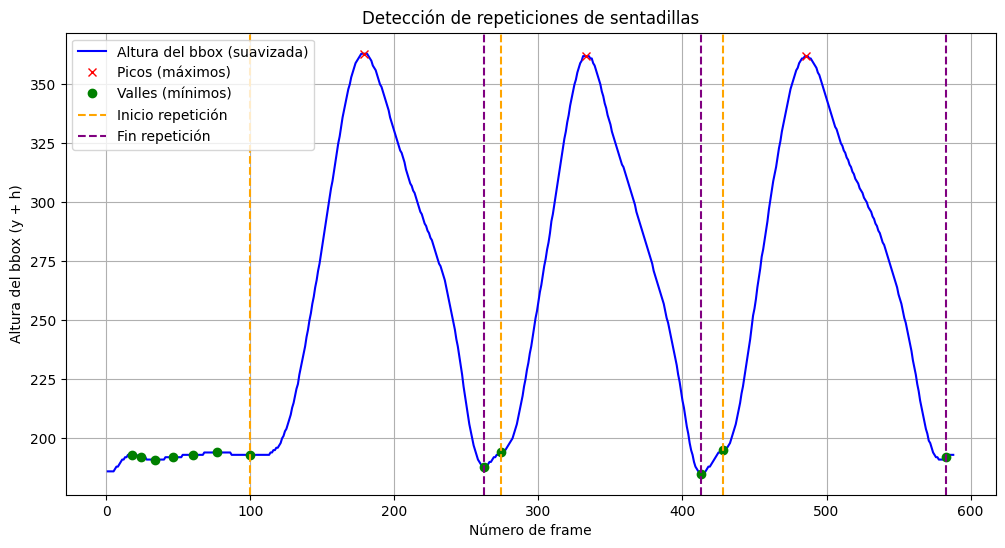

Repetición 1:
  - Inicio: Frame 100
  - Pico: Frame 178
  - Fin:    Frame 262
Repetición 2:
  - Inicio: Frame 274
  - Pico: Frame 332
  - Fin:    Frame 413
Repetición 3:
  - Inicio: Frame 428
  - Pico: Frame 485
  - Fin:    Frame 583


In [28]:
start_frames, end_frames, peaks = detect_squat_repetitions(bbox_heights=bbox_heights,
                                                        frame_numbers=frame_numbers,
                                                        output_path=f"{output_path}{video}")

In [29]:
video = "video_1"
input_video = f"data/input/{video}.mp4" 
output_path = f"data/output/"

create_video(video_path=input_video, output_path=output_path,
             start_frames=start_frames, end_frames=end_frames,
             peaks=peaks, sec_pause=3, initial_frame=initial_frame)

I0000 00:00:1740711325.016168  105833 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1740711325.040510  113511 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA GeForce GTX 1060 6GB/PCIe/SSE2
W0000 00:00:1740711325.115880  113508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1740711325.157708  113509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-

Video procesado y guardado en data/output/video_1/result.mp4


[out#0/mp4 @ 0x59d6962f4900] video:1006kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.376435%
frame= 2019 fps=604 q=-1.0 Lsize=    1030kB time=00:00:38.03 bitrate= 221.7kbits/s speed=11.4x    
[libx264 @ 0x59d6962f6100] frame I:9     Avg QP:19.73  size: 27541
[libx264 @ 0x59d6962f6100] frame P:676   Avg QP:22.02  size:  1029
[libx264 @ 0x59d6962f6100] frame B:1334  Avg QP:30.20  size:    64
[libx264 @ 0x59d6962f6100] consecutive B-frames:  6.3% 15.6%  3.4% 74.7%
[libx264 @ 0x59d6962f6100] mb I  I16..4:  6.1% 80.4% 13.5%
[libx264 @ 0x59d6962f6100] mb P  I16..4:  0.3%  1.6%  0.1%  P16..4: 10.4%  3.3%  2.4%  0.0%  0.0%    skip:81.8%
[libx264 @ 0x59d6962f6100] mb B  I16..4:  0.0%  0.1%  0.0%  B16..8:  4.1%  0.1%  0.0%  direct: 0.0%  skip:95.7%  L0:35.4% L1:63.8% BI: 0.8%
[libx264 @ 0x59d6962f6100] 8x8 transform intra:80.1% inter:69.9%
[libx264 @ 0x59d6962f6100] coded y,uvDC,uvAC intra: 56.6% 44.5% 8.8% inter: 1.6% 1.1% 0.1%
[libx264 @ 0x59d6962f6100] i16 

In [30]:
display_video(f"{output_path}{video}/result.mp4")

# **Conclusión**

En este notebook, se logró captar los momentos clave de una sentadilla: **inicio**, **punto mínimo** y **finalización** en cada repetición. 🎯 Se utilizó para hacer pruebas y ver resultados gráficamente, permitiendo ajustes y mejoras. Finalmente, se obtuvo un **script funcional** que se integrará al código principal de Python para completar el proyecto. 

¡Objetivo cumplido! 🚀
